Our goal is to approach this problem from two sides: first - looking at the maximal flow we can achieve, and then finding the maximal heat transfer for that flow.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pint import UnitRegistry

import scipy as sp
from scipy import optimize as op

from fluid import Fluid

import json

I'll start by defining some basic helper functions

In [19]:
water = Fluid('water')

def Re(D, v, rho, mu):
    return rho*v*D/mu

def Nu(Re, Pr):
    if Re < 2300:
        return 3.66
    elif Re > 2300 and Re < 10000:
        return 4.36
    else:
        return 0.023*Re**(4/5)*Pr**(0.4)
    
def Nu_turbulent(Re, Pr):
    return 0.023*Re**(4/5)*Pr**(0.4)

def h(Nu, k, D):
    return Nu*k/D

def R_cond(k, A, t):
    return k*A/t

def R_conv(h, A):
    return 1/h*A

def u_avg(m_dot, rho, A):
    return m_dot/(rho*A)

def HydraulicDiameter(A, P):
    return 4*A/P

def T_o(Ti, m_dot, Cp):
    return (m_dot*Cp*Ti)/(m_dot*Cp)



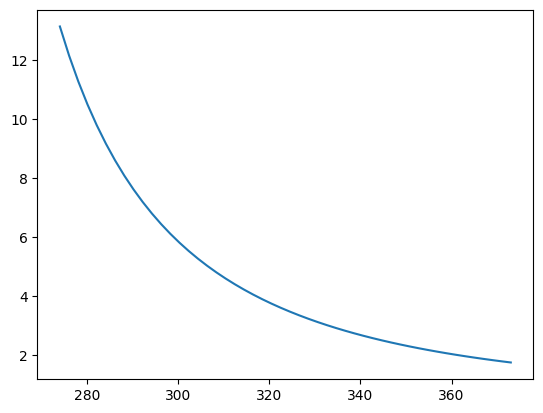

In [20]:
ts = np.linspace(274, 373, 50)
prs = np.zeros_like(ts)
for i,t in enumerate(ts):
    Pr = water.prandtl(P=101325, T=t)
    prs[i] = Pr
plt.plot(ts, prs)
plt.show()

Here are the equations and symbol definitions in LaTeX format:

Equations:
1. Energy balance equation on the top surface:
$$
q_{\text{{sun}}} \cdot \epsilon - h_{\text{{air}}} \cdot (T_h - T_{\text{{inf}}}) - \epsilon \cdot \sigma \cdot T_h^4 - \frac{{k_{\text{{module}}} \cdot (T_l - T_h)}}{{\text{{thickness}}}} = 0
$$

2. Heat transfer equation for the module:
$$
\frac{{k_{\text{{module}}} \cdot (T_l - T_h)}}{{\text{{thickness}}}} - \text{{Nu}}_{\text{{turbulent}}} \cdot \left(\frac{{k_{\text{{water}}}}}{{D}}\right) \cdot \text{{LMTD}}(T_l, T_l, T_{\text{{ci}}}, T_{\text{{co}}}) = 0
$$

3. Heat transfer equation for the coolant:
$$
\frac{{k_{\text{{module}}} \cdot (T_l - T_h)}}{{\text{{thickness}}}} - \dot{m}_{1D}(T_{\text{{ci}}}) \cdot C_p(T_{\text{{ci}}}) \cdot (T_{\text{{co}}} - T_{\text{{ci}}}) = 0
$$

Symbol Definitions:
- $q_{\text{{sun}}}$: Solar flux ($W/m^2$)
- $T_{\text{{inf}}}$: Inlet temperature of the air (K)
- $T_{\text{{ci}}}$: Inlet temperature of the coolant (K)
- $h_{\text{{air}}}$: Convective heat transfer coefficient of the air ($W/(m^2C$))
- $\epsilon$: Emissivity of the module
- $\sigma$: Stefan-Boltzmann constant ($5.67 \times 10^{-8}$ ($W/(m^2C^4$))
- $k_{\text{{water}}}$: Thermal conductivity of the coolant ($W/(m\cdot K$))
- $k_{\text{{module}}}$: Thermal conductivity of the module ($W/(m\cdot K$))
- $\text{{thickness}}$: Thickness of the module (m)
- $D$: Hydraulic diameter of the coolant channel (m)
- $v$: Velocity of the coolant (m/s)
- $P$: Pressure of the coolant (Pa)
- $C_p$: Specific heat capacity of the coolant (J/(kg$\cdot$K))
- $\text{{Nu}}_{\text{{turbulent}}}$: Nusselt number for turbulent flow
- $\text{{LMTD}}$: Logarithmic mean temperature difference
- $\dot{m}_{1D}$: Mass flow rate of the coolant (kg/s)

In [21]:
# equation 1: energy balance on the top surface
def make_optimizer_egns(q_sun, T_inf, T_ci, h_air,
                        epsilon, sigma, k_module, k_water,
                        thickness, D, v, P=101325):
    Cp = lambda t: water.cpmass(P=P, T=t)
    module_conductivity = lambda Tl, Th : k_module  * (Th-Tl) / thickness
    m_dot_1d = lambda t: water.density(P=P, T=t) * v
    lmtd = lambda Tai, Tao, Tbi, Tbo: ((Tao-Tbo) - (Tai - Tbi))/(np.log(Tao-Tbo) - np.log(Tai-Tbi))
    he_Re = lambda t: Re(D, v, water.density(P=P, T=t), water.viscosity(P=P, T=t))
    he_Pr = lambda t:water.prandtl(P=P, T=t)
    he_Nu = lambda t: Nu_turbulent(he_Re(t), he_Pr(t))
    def equations(T):
        #print(f"Re: {he_Re(T_ci)}, Pr: {he_Pr(T_ci)}, Nu: {he_Nu(T_ci)}")
        T_h, T_l, T_co = T
        #print(T_h, T_l, T_ci, T_co)
        return [
            q_sun * (epsilon) - h_air*(T_h-T_inf) - epsilon * sigma * T_h**4 - module_conductivity(T_l, T_h), #todo add rho
            module_conductivity(T_l, T_h) - he_Nu(T_ci) * (k_water/ D) * lmtd(T_l, T_l, T_ci, T_co) , #todo check heat flux is correct
            module_conductivity(T_l, T_h) - m_dot_1d(T_ci) * Cp(T_ci) * (T_co-T_ci),
        ]
    return equations

    
    
    
a = 3.5e-3
b = 30e-3

param_dict = {
    "q_sun": 5e2*163, # W/m^2
    "T_inf": 300.15,
    "T_ci":285,#294.261, # https://edis.ifas.ufl.edu/publication/CH182,
    "h_air": 33.,
    "epsilon": 1,
    "sigma": 5.67e-8,
    "k_module": 1.72,
    "k_water": 0.6,
    "thickness": 3.5e-3, # m
    "D": 4 * (a*b)/(2*(a+b)), # hydraulic diameter of a rectangle
    "v": 1.219 / 2, # https://extension.usu.edu/irrigation/research/accurate-irrigation-water-flow-pipes
    "P": 413685.0,
    }

eqns = make_optimizer_egns(**param_dict)
T_l_init = 0.5 * (param_dict['T_inf'] + param_dict['T_ci'])
# use scipy to solve the system of equations
ts = op.least_squares(eqns,
                     [param_dict['T_inf'], T_l_init, 275],
                     bounds=([0, 0, 275],
                             [np.inf, np.inf, 373]))
# convert ts.x to a dictionary and put in celsius
T_h, T_l, T_co = [t-273.15 for t in ts.x]
print(f"T_h: {T_h:.2f} C, T_l: {T_l:.2f} C, T_co: {T_co:.2f} C")

T_h: 184.66 C, T_l: 34.47 C, T_co: 11.88 C


/tmp/ipykernel_415282/1245737327.py:8: RuntimeWarning: invalid value encountered in log
  lmtd = lambda Tai, Tao, Tbi, Tbo: ((Tao-Tbo) - (Tai - Tbi))/(np.log(Tao-Tbo) - np.log(Tai-Tbi))


In [22]:
param_dict['D']

0.00626865671641791

In [23]:
solar_flux_ratio = np.pi * (1.5/2) / (30e-3*4)**2

<Axes: xlabel='Timestamp'>

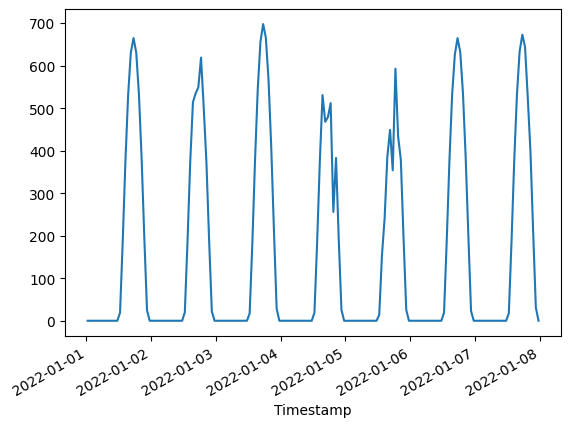

In [24]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('1026619_28.05_-81.70_2022.csv')

# Combine the Year, Month, Day, Hour, and Minute into a single timestamp column
df['Timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Drop the original Year, Month, Day, Hour, and Minute columns
df = df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

# Convert the index to a DatetimeIndex
df = df.set_index('Timestamp')

# plot a week of data
df.loc['2022-01-01':'2022-01-07']['GHI'].plot()

<Axes: xlabel='Timestamp'>

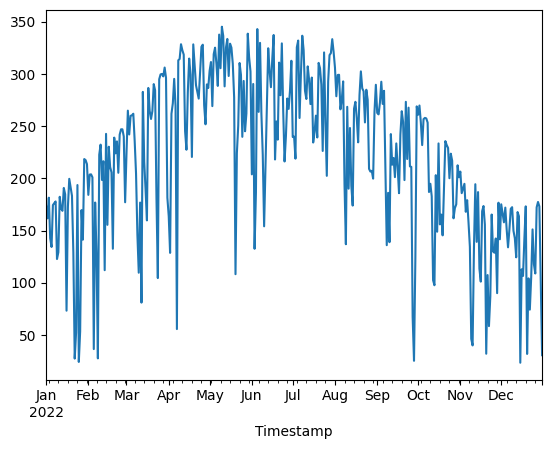

In [25]:
# plot average daily GHI
df['GHI'].resample('D').mean().plot()


What I want to do next is create a for loop, with each loop, for each data point, I'll calculate the final temperature difference, and then the voltage/wattage from the thermal electric generator. Then, we'll be able to find average, maximum and minimum voltage/wattage. 

In [26]:
df['Temperature']

Timestamp
2022-01-01 00:30:00    22.5
2022-01-01 01:30:00    21.5
2022-01-01 02:30:00    20.3
2022-01-01 03:30:00    19.3
2022-01-01 04:30:00    18.6
                       ... 
2022-12-31 19:30:00    25.1
2022-12-31 20:30:00    24.5
2022-12-31 21:30:00    23.0
2022-12-31 22:30:00    21.5
2022-12-31 23:30:00    21.0
Name: Temperature, Length: 8760, dtype: float64

In [27]:
# loop through the data
t_diffs = []
for i, row in df.iterrows():
    if row['GHI'] < 0.1:
        t_diffs.append(0)
        continue
    param_dict = {
    "q_sun": row['GHI'] * solar_flux_ratio, # W/m^2
    "T_inf": row['Temperature'] + 274.15,
    "T_ci":284.,##294.261, # https://edis.ifas.ufl.edu/publication/CH182,
    "h_air": 33.,
    "epsilon": 1,
    "sigma": 5.67e-8,
    "k_module": 1.72,
    "k_water": 0.6,
    "thickness": 3.5e-3, # m
    "D": 4 * (a*b)/(2*(a+b)), # hydraulic diameter of a rectangle
    "v": 1.219 / 2, # https://extension.usu.edu/irrigation/research/accurate-irrigation-water-flow-pipes
    "P": 413685.0,
    }
    eqns = make_optimizer_egns(**param_dict)
    T_l_init = 0.5 * (param_dict['T_inf'] + param_dict['T_ci'])
    # use scipy to solve the system of equations
    if param_dict['T_inf'] - param_dict['T_ci'] < 5:
        t_diffs.append(0)
        continue
    try:
        t = op.least_squares(eqns,
                            [param_dict['T_inf'], T_l_init, 275],
                            bounds=([0, 0, 275],
                                    [np.inf, np.inf, 373]))
    except ValueError as e:
        print("Error found with the following initial conditions:")
        print(f"T_h: {param_dict['T_inf']:.2f} C, T_l: {T_l_init:.2f} C, T_co: {275:.2f} C")
    t_diff = ts.x[0] - ts.x[1]
    t_diffs.append(t_diff)

# add the temperature difference to the dataframe
df['Temperature Difference'] = t_diffs

/tmp/ipykernel_415282/1245737327.py:8: RuntimeWarning: invalid value encountered in log
  lmtd = lambda Tai, Tao, Tbi, Tbo: ((Tao-Tbo) - (Tai - Tbi))/(np.log(Tao-Tbo) - np.log(Tai-Tbi))


<Axes: xlabel='Timestamp'>

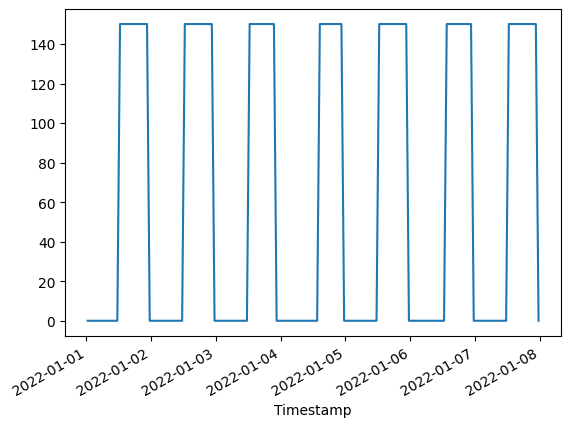

In [28]:
# plot the first week of temperature differences
df.loc['2022-01-01':'2022-01-07']['Temperature Difference'].plot()

Equations were pulled from data fitted from the data sheet of the TEG

The average energy produced per day is: 27.94 Wh
The average wattage produced is: 1.16 W


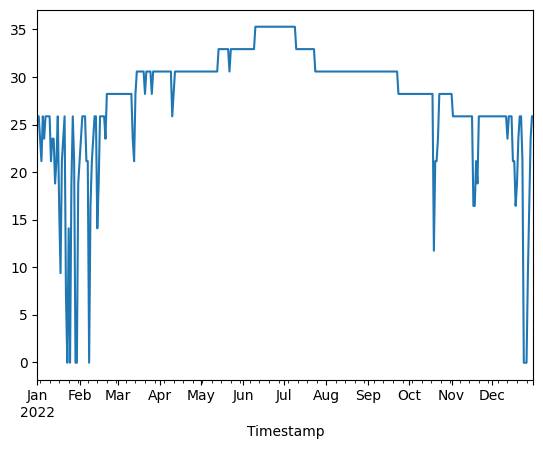

In [29]:
v = lambda t: -.856 + 0.0281*(t+25) + -2.31e-5*(t+25)**2
I = lambda t: -.123 + 5.68e-3*(t+25) -5.57e-6*(t+25)**2

# add the voltage, current and wattage to the dataframe
df['Voltage'] = v(df['Temperature Difference'])
df['Current'] = I(df['Temperature Difference'])
df['Wattage'] = df['Voltage'] * df['Current']

# find the total energy produced per day
df['Wattage'].resample('D').sum().plot()

# find the total energy produced per day
total_energy_per_day = df['Wattage'].resample('D').sum()
average_energy_per_day = total_energy_per_day.mean()
print(f"The average energy produced per day is: {average_energy_per_day:.2f} Wh")

# find the average wattage
average_wattage = df['Wattage'].mean()
print(f"The average wattage produced is: {average_wattage:.2f} W")


In [30]:
# Assuming 'df' is your DataFrame and the index is already a DateTimeIndex.

# Extract the hour from the index and create a new column for it
df['Hour'] = df.index.hour

# Group by hour and collect temperature differences into lists
grouped = df.groupby('Hour')['Temperature Difference'].apply(list).reset_index(name='Temperature Difference')

# Explode the list into separate rows
grouped = grouped.explode('Temperature Difference')

# Pivot the DataFrame to have hours as columns
pivoted = grouped.pivot(columns='Hour', values='Temperature Difference')

# Plotting
plt.figure(figsize=(12, 8))
pivoted.boxplot()
plt.title('Hourly Boxplot of Temperature Difference Over the Year')
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature Difference')
plt.grid(True)
plt.show()


ValueError: Index contains duplicate entries, cannot reshape